In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

action = 'Shallow'

ik_path = f"C:/Users/Hanif/OneDrive - UNSW/T3 - 2025/Biomechanics of Human Body/Final Project/Vicon Data/{action} Squat/IK"
ik_files = [f for f in os.listdir(ik_path) if f.endswith('.mot')]

cmc_path = f"C:/Users/Hanif/OneDrive - UNSW/T3 - 2025/Biomechanics of Human Body/Final Project/Vicon Data/{action} Squat/CMC"
cmc_folders = [f for f in os.listdir(cmc_path)]


dfs =[pd.read_csv(os.path.join(cmc_path, cmc_folder, "Hanif-Scaled_states.sto"), sep='\t', skiprows=6, comment="#") for cmc_folder in cmc_folders]

print(dfs[0].columns.tolist())


# dfs =[pd.read_csv(os.path.join(ik_path, ik_file), sep='\t', skiprows=10, comment="#") for ik_file in ik_files]


['time', '/jointset/ground_pelvis/pelvis_tilt/value', '/jointset/ground_pelvis/pelvis_tilt/speed', '/jointset/ground_pelvis/pelvis_list/value', '/jointset/ground_pelvis/pelvis_list/speed', '/jointset/ground_pelvis/pelvis_rotation/value', '/jointset/ground_pelvis/pelvis_rotation/speed', '/jointset/ground_pelvis/pelvis_tx/value', '/jointset/ground_pelvis/pelvis_tx/speed', '/jointset/ground_pelvis/pelvis_ty/value', '/jointset/ground_pelvis/pelvis_ty/speed', '/jointset/ground_pelvis/pelvis_tz/value', '/jointset/ground_pelvis/pelvis_tz/speed', '/jointset/hip_r/hip_flexion_r/value', '/jointset/hip_r/hip_flexion_r/speed', '/jointset/hip_r/hip_adduction_r/value', '/jointset/hip_r/hip_adduction_r/speed', '/jointset/hip_r/hip_rotation_r/value', '/jointset/hip_r/hip_rotation_r/speed', '/jointset/knee_r/knee_angle_r/value', '/jointset/knee_r/knee_angle_r/speed', '/jointset/ankle_r/ankle_angle_r/value', '/jointset/ankle_r/ankle_angle_r/speed', '/jointset/subtalar_r/subtalar_angle_r/value', '/joints

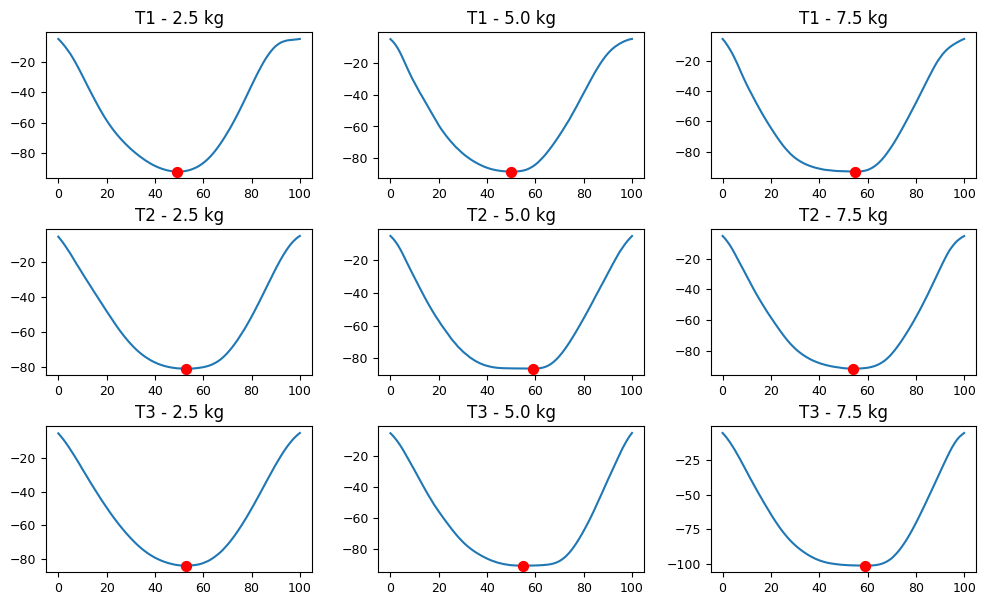

In [2]:
fig, axes = plt.subplots(3, 3, figsize=(10,6))
axes = axes.flatten()

start_idx_all = []
end_idx_all = []

for index, (df, ik_file) in enumerate(zip(dfs, ik_files)):

  parts = ik_file.split("_")  
  # ['1', 'Hanif', 'Deep', '2', '5']

  trial = parts[0]
  name = parts[1]
  depth = parts[2]
  load = float(parts[3] + "." + parts[4])

  time  = df["time"].values
  angle = df["knee_angle_r"].values  # or whatever your column is called

  # 1) subtract baseline (first N frames)
  baseline   = angle[:30].mean()
  angle_rel  = angle - baseline

  # 2) choose start/end indices

  moving_idx = np.where(np.abs(angle_rel) > 5)[0]
  start_idx  = moving_idx[0]
  end_idx    = moving_idx[-1]

  start_idx_all.append(start_idx)
  end_idx_all.append(end_idx)

  t_seg   = time[start_idx:end_idx+1]
  ang_seg = angle_rel[start_idx:end_idx+1]

  # 3) normalize to 0–100% (101 points)
  t_target = np.linspace(t_seg[0], t_seg[-1], 101)
  ang_norm = np.interp(t_target, t_seg, ang_seg)

  # where is the bottom?
  idx_bottom = np.argmin(ang_norm)   # more flexion = more negative
  bottom_pc  = idx_bottom            # 0–100 index == % of cycle

  ax = axes[index]
  ax.plot(np.linspace(0,100,101), ang_norm)
  ax.scatter(idx_bottom, ang_norm[idx_bottom], color='red', s=50, zorder=5)  
  ax.set_title(f"T{trial} - {load} kg")
  ax.set_xlabel("")   # remove axis clutter
  ax.set_ylabel("")
  ax.tick_params(axis='both', which='major', labelsize=9)
  ax.tick_params(axis='both', which='major', labelsize=9)

plt.subplots_adjust(
    left=0.05, right=0.98,
    top=0.95, bottom=0.05,
    wspace=0.25, hspace=0.35
)

plt.show()


36.910012
33.1474415692
56.01089654039999
29.526530746000013
47.611586142
50.75315539639999
37.078504006
46.486106209599974
59.933388603199994


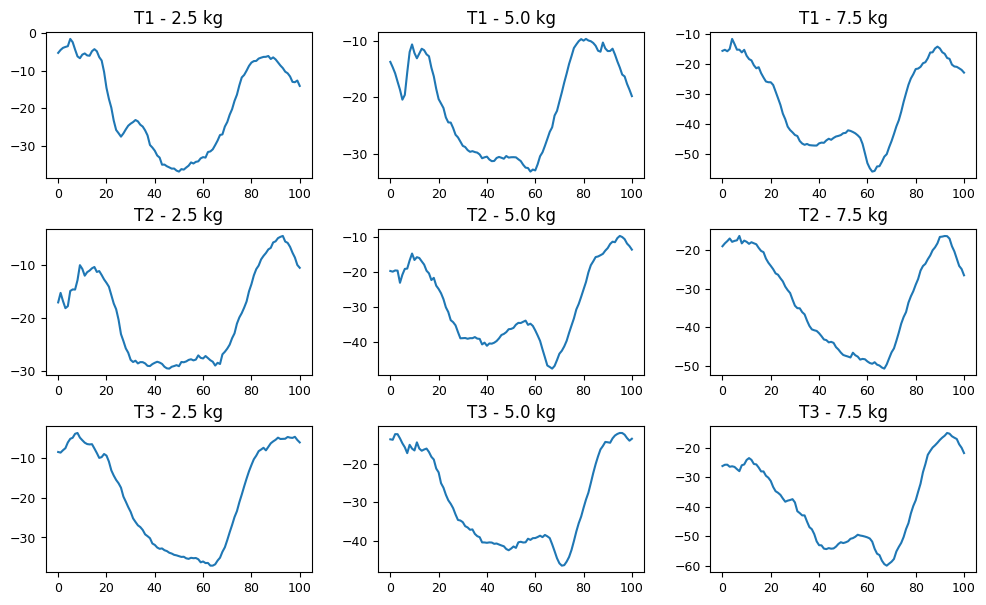

In [3]:
id_path = f"C:/Users/Hanif/OneDrive - UNSW/T3 - 2025/Biomechanics of Human Body/Final Project/Vicon Data/{action} Squat/ID"
id_files = [f for f in os.listdir(id_path) if f.endswith('.sto')]
dfs_id =[pd.read_csv(os.path.join(id_path, id_file), sep='\t', skiprows=6) for id_file in id_files]

fig, axes = plt.subplots(3, 3, figsize=(10,6))
axes = axes.flatten()

mom_2_5_hip = []   # trial1, trial2, trial3
mom_5_0_hip = []
mom_7_5_hip = []
mom_2_5_knee = []   # trial1, trial2, trial3
mom_5_0_knee = []
mom_7_5_knee = []


for index, (df, ik_file) in enumerate(zip(dfs_id, ik_files)):

  parts = ik_file.split("_")  
  # ['1', 'Hanif', 'Deep', '2', '5']

  trial = parts[0]
  name = parts[1]
  depth = parts[2]
  load = float(parts[3] + "." + parts[4])

  time_id = df['time'].values
  hip_moment_r = df['hip_flexion_r_moment'].values
  knee_angle_r = df['knee_angle_r_moment'].values

  # --- Use your IK start_idx and end_idx from earlier ---
  start_idx = start_idx_all[index]
  end_idx = end_idx_all[index]
  t_seg_id   = time_id[start_idx:end_idx+1]
  mom_seg_hip    = hip_moment_r[start_idx:end_idx+1]
  mom_seg_knee    = knee_angle_r[start_idx:end_idx+1]


  # --- Normalize to 101 points ---
  t_target = np.linspace(t_seg_id[0], t_seg_id[-1], 101)
  mom_norm_hip = np.interp(t_target, t_seg_id, mom_seg_hip)
  mom_norm_knee = np.interp(t_target, t_seg_id, mom_seg_knee)


  # --- Extract peak moment ---
  peak_moment_hip = np.max(abs(mom_norm_hip))
  peak_moment_knee = np.max(abs(mom_norm_knee))

  # as you loop through each trial, append:
  if load == 2.5:
      mom_2_5_hip.append(mom_norm_hip)
      mom_2_5_knee.append(mom_norm_knee)
  elif load == 5.0:
      mom_5_0_hip.append(mom_norm_hip)
      mom_5_0_knee.append(mom_norm_knee)
  elif load == 7.5:
      mom_7_5_hip.append(mom_norm_hip)
      mom_7_5_knee.append(mom_norm_knee)
      
  ax = axes[index]
  ax.plot(np.linspace(0,100,101), mom_norm_hip)
  ax.set_title(f"T{trial} - {load} kg")
  ax.set_xlabel("")   # remove axis clutter
  ax.set_ylabel("")
  ax.tick_params(axis='both', which='major', labelsize=9)
  ax.tick_params(axis='both', which='major', labelsize=9)

  print(peak_moment_hip)

plt.subplots_adjust(
    left=0.05, right=0.98,
    top=0.95, bottom=0.05,
    wspace=0.25, hspace=0.35
)

plt.show()


Peak 33.55804794333333 37.95106217626665 53.81492840826667


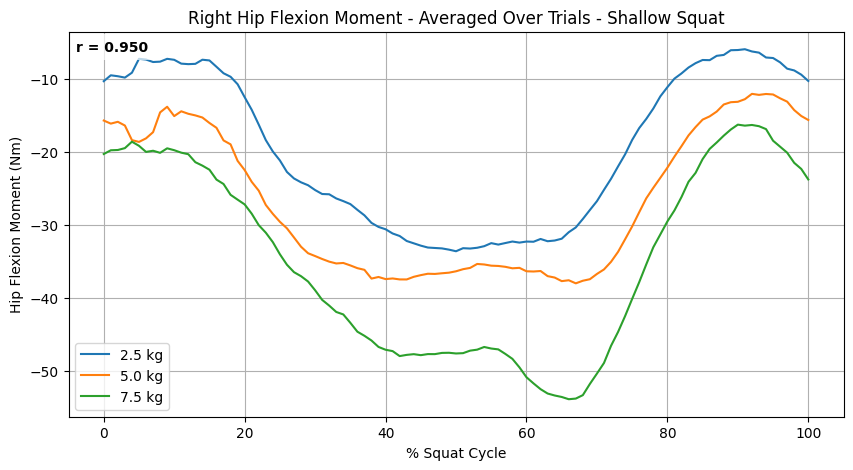

Pearson r = 0.9504917523628393


In [4]:
mean_25_hip = np.mean(np.vstack(mom_2_5_hip), axis=0)
mean_50_hip = np.mean(np.vstack(mom_5_0_hip), axis=0)
mean_75_hip = np.mean(np.vstack(mom_7_5_hip), axis=0)
x = np.linspace(0, 100, 101)

plt.figure(figsize=(10,5))
plt.plot(x, mean_25_hip, label="2.5 kg")
plt.plot(x, mean_50_hip, label="5.0 kg")
plt.plot(x, mean_75_hip, label="7.5 kg")

plt.title(f"Right Hip Flexion Moment - Averaged Over Trials - {action} Squat")
plt.xlabel("% Squat Cycle")
plt.ylabel("Hip Flexion Moment (Nm)")
plt.legend()
plt.grid(True)

peak25_hip = np.max(np.abs(mean_25_hip))
peak50_hip = np.max(np.abs(mean_50_hip))
peak75_hip = np.max(np.abs(mean_75_hip))

print(f"Peak {peak25_hip} {peak50_hip} {peak75_hip}" )

load_array = np.array([2.5, 5.0, 7.5])
peak_array = np.array([peak25_hip, peak50_hip, peak75_hip])

r = np.corrcoef(load_array, peak_array)[0,1]

plt.text(
    0.01, 0.95,
    f"r = {r:.3f}",
    transform=plt.gca().transAxes,
    fontsize=10,          # bigger
    fontweight='bold',    # bold
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.show()

print("Pearson r =", r) 

Peak 71.49433368093331 64.17929247186667 62.77500632133333


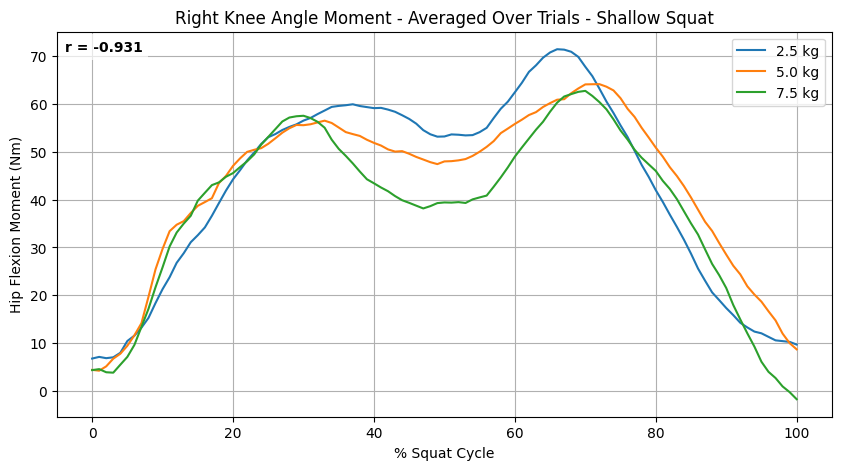

Pearson r = -0.9312186653679765


In [5]:
mean_25_knee = np.mean(np.vstack(mom_2_5_knee), axis=0)
mean_50_knee = np.mean(np.vstack(mom_5_0_knee), axis=0)
mean_75_knee = np.mean(np.vstack(mom_7_5_knee), axis=0)
x = np.linspace(0, 100, 101)

plt.figure(figsize=(10,5))
plt.plot(x, mean_25_knee, label="2.5 kg")
plt.plot(x, mean_50_knee, label="5.0 kg")
plt.plot(x, mean_75_knee, label="7.5 kg")

plt.title(f"Right Knee Angle Moment - Averaged Over Trials - {action} Squat")
plt.xlabel("% Squat Cycle")
plt.ylabel("Hip Flexion Moment (Nm)")
plt.legend()
plt.grid(True)


peak25_knee = np.max(np.abs(mean_25_knee))
peak50_knee = np.max(np.abs(mean_50_knee))
peak75_knee = np.max(np.abs(mean_75_knee))

print(f"Peak {peak25_knee} {peak50_knee} {peak75_knee}" )

load_array = np.array([2.5, 5.0, 7.5])
peak_array = np.array([peak25_knee, peak50_knee, peak75_knee])

r = np.corrcoef(load_array, peak_array)[0,1]

plt.text(
    0.01, 0.95,
    f"r = {r:.3f}",
    transform=plt.gca().transAxes,
    fontsize=10,          # bigger
    fontweight='bold',    # bold
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
)

plt.show()
print("Pearson r =", r) 